In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections

from PyHEADTAIL_feedback.feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL_feedback.derived_processors import Bypass
from PyHEADTAIL_feedback.processors import ChargeWeighter, Averager

np.random.seed(0)

PyHEADTAIL v1.9.4




In [ ]:
""" 
    This example shows howto use ideal feedback systems in PyHEADTAIL simulations. In order to avoid writing
    unnecessary code here, the used bunch, slicer and transfer maps are created with a function written to
    file test_tools.py in this folder.
"""

In [2]:
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

# feedback_gain = 0.1
feedback_gain = (0.1,0.4)
n_turns = 150

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(n_macroparticles,n_segments, n_slices,n_sigma_z)

In [3]:

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [4]:
# The simplest possible feedback is a bunch feedback. It takes the mean_xp and mean_yp values of the bunch 
# and correct those values a fraction of gain.

bunch_IdealBunchFB = copy.deepcopy(bunch_ref)
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)

feedback_map = IdealBunchFeedback(feedback_gain)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_IdealBunchFB,total_map_FB,tracker_IdealBunchFB)

In [5]:
# The most ideal feedback is slice feedback. It takes the mean_xp and mean_yp values for each slice and 
# correct them a fraction of gain.

bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
slicer_IdealSliceFB = copy.deepcopy(slicer_ref)

feedback_map = IdealSliceFeedback(feedback_gain,slicer_IdealSliceFB)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_IdealSliceFB,total_map_FB,tracker_IdealSliceFB)

In [6]:
# The more complex 


bunch_OneBox_slice = copy.deepcopy(bunch_ref)
tracker_OneBox_slice = BunchTracker(bunch_OneBox_slice)
slicer_OneBox_slice = copy.deepcopy(slicer_ref)

# signal processor chains
processors_slice_x = [Bypass()]
processors_slice_y = [Bypass()]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_slice,processors_slice_x,processors_slice_y)
total_map_OneBox_slice = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_slice,total_map_OneBox_slice,tracker_OneBox_slice)

In [7]:
bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

# signal processor chains
processors_bunch_x = [ChargeWeighter(normalization = 'average_weight'),Averager()]
processors_bunch_y = [ChargeWeighter(normalization = 'average_weight'),Averager()]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y)
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)

400 elements is calculated
400 elements is calculated


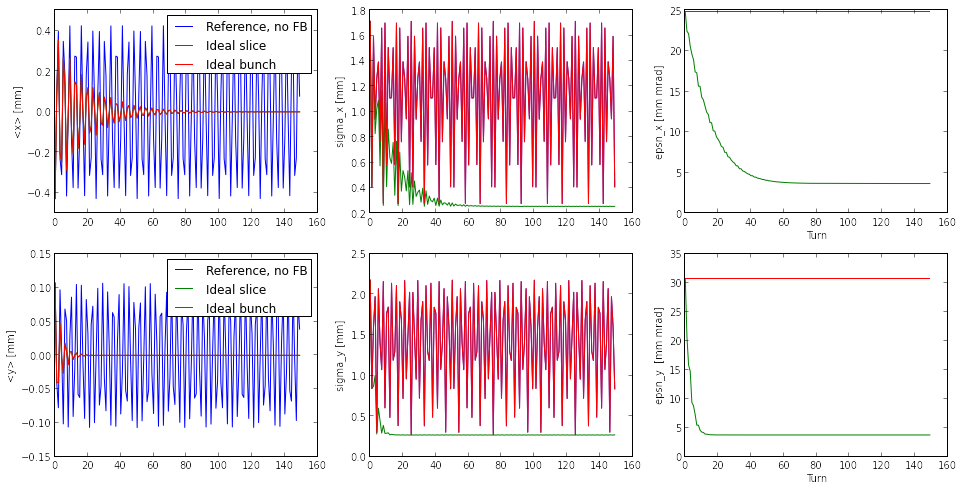

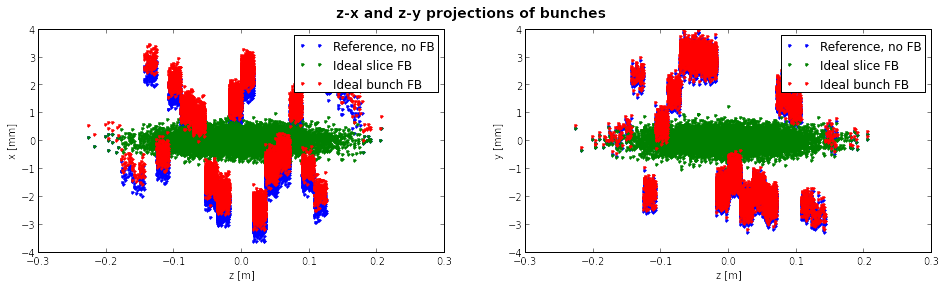

In [8]:
compare_traces([tracker_ref,tracker_IdealSliceFB,tracker_IdealBunchFB],
               ['Reference, no FB', 'Ideal slice', 'Ideal bunch'])
compare_projections([bunch_init, bunch_IdealSliceFB, bunch_IdealBunchFB], 
                    ['Reference, no FB', 'Ideal slice FB', 'Ideal bunch FB'])

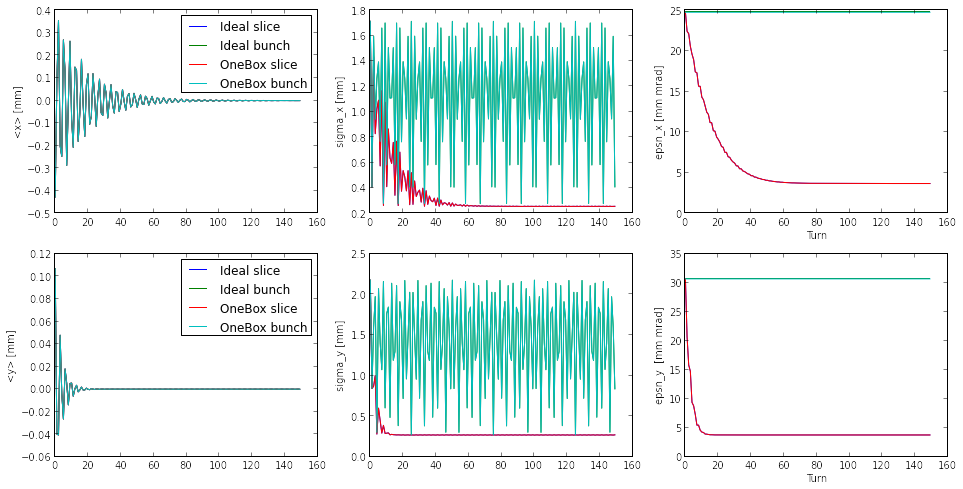

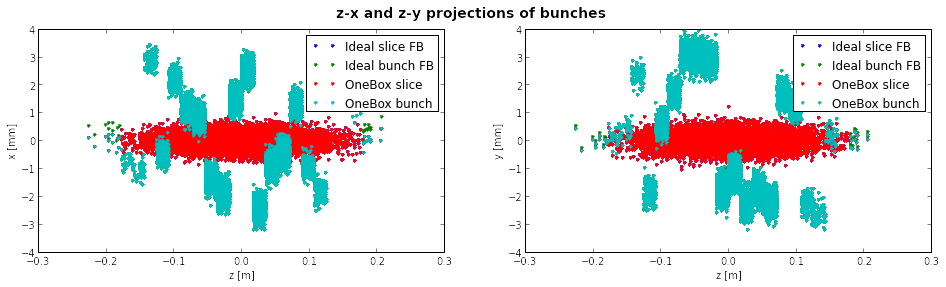

In [9]:
compare_traces([tracker_IdealSliceFB,tracker_IdealBunchFB, tracker_OneBox_slice, tracker_OneBox_bunch],
               ['Ideal slice', 'Ideal bunch','OneBox slice', 'OneBox bunch'])
compare_projections([bunch_IdealSliceFB, bunch_IdealBunchFB,bunch_OneBox_slice,bunch_OneBox_bunch], 
                    ['Ideal slice FB', 'Ideal bunch FB','OneBox slice', 'OneBox bunch'])